In [1]:
from sklearn.datasets import load_iris # import the iris dataset

iris_data = load_iris()

In [2]:
#get the features and labels of the dataset
features = iris_data.data
labels = iris_data.target

In [27]:
import numpy as np
num_classes = len(np.unique(labels))

num_features = features.shape[1]
print('특성 개수  :',num_features)
print('클래스 개수:',num_classes)

특성 개수  : 4
클래스 개수: 3


In [3]:
from sklearn.preprocessing import MinMaxScaler # import the MinMaxScaler for scaling the features

features = MinMaxScaler().fit_transform(features)

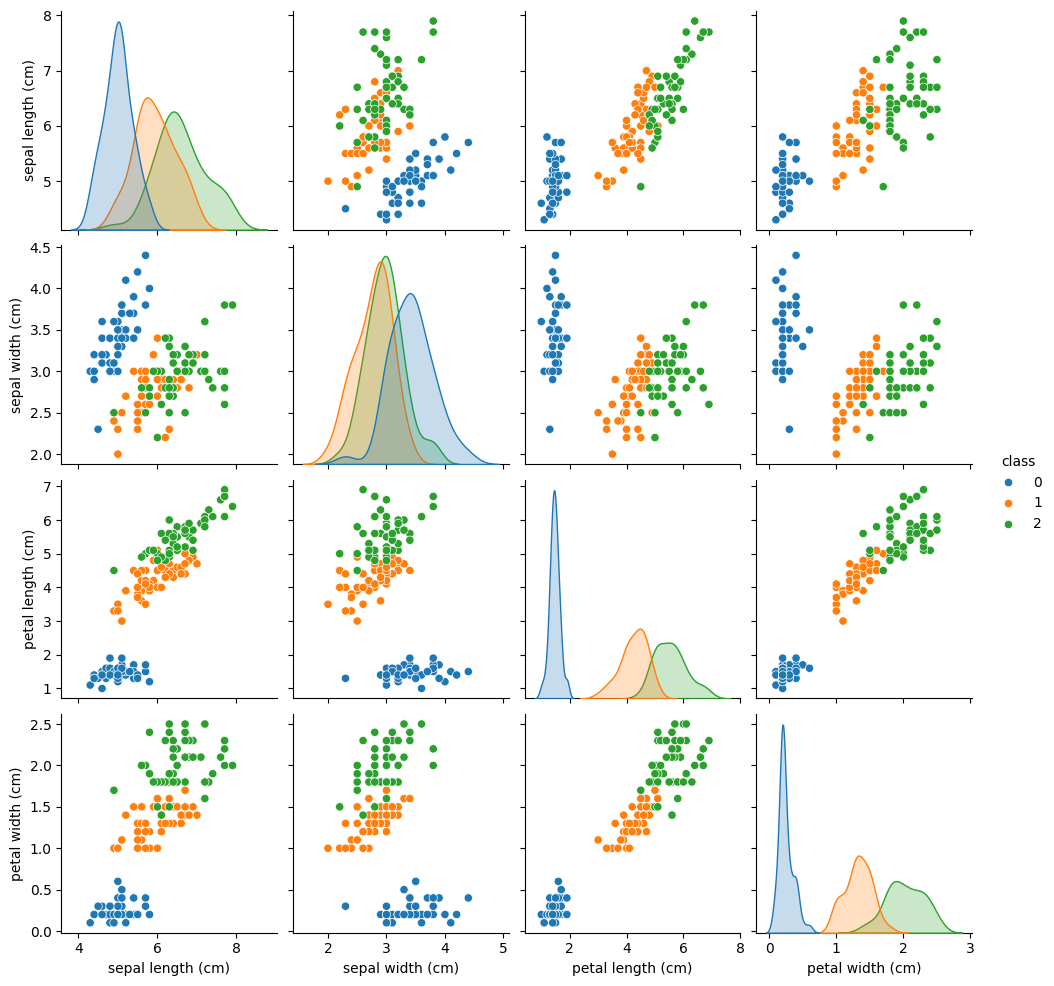

In [4]:
import pandas as pd
import seaborn as sns
# convert the features and labels to a pandas dataframe
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

# plot the data using seaborn
sns.pairplot(df, hue="class", palette="tab10")

In [6]:
from sklearn.model_selection import train_test_split

from qiskit_algorithms.utils import algorithm_globals
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
) 

In [7]:
from sklearn.svm import SVC 

# create the SVC model and train it
svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [8]:
train_score_c4 = svc.score(train_features, train_labels)
test_score_c4 = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score_c4:.2f}")
print(f"Classical SVC on the test dataset:     {test_score_c4:.2f}")

Classical SVC on the training dataset: 0.99
Classical SVC on the test dataset:     0.97


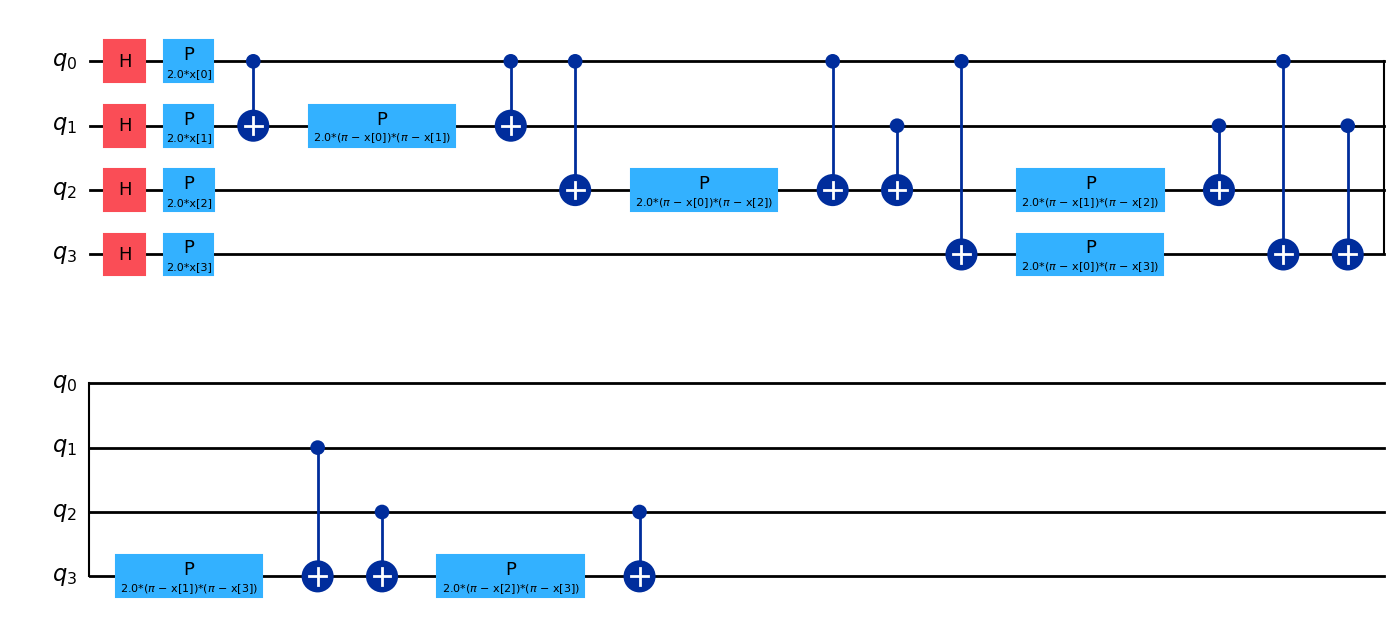

In [9]:
from qiskit.circuit.library import ZZFeatureMap



# create the feature map for the quantum model
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

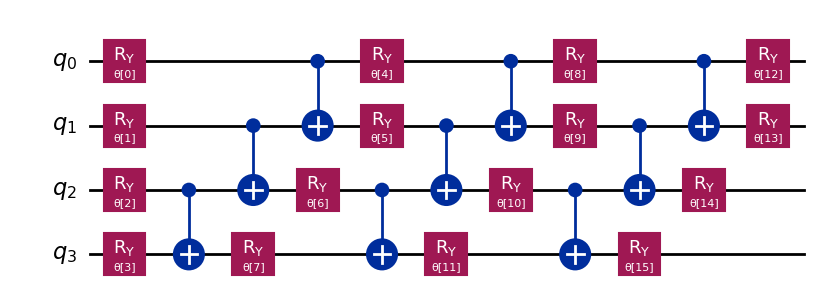

In [10]:
from qiskit.circuit.library import RealAmplitudes

# create the ansatz for the quantum model
# we use the RealAmplitudes ansatz with 3 repetitions
# and the number of qubits equal to the number of features
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", fold=20)

In [12]:
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, ADAM, SLSQP, AQGD
# create the optimizer for the quantum model 
# we use the COBYLA optimizer with 100 iterations
# and a tolerance of 0.0001
optimizer = COBYLA(maxiter=100)

In [13]:
from qiskit.primitives import StatevectorSampler as Sampler
sampler = Sampler()

In [14]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

# create a list to store the objective function values
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# define the callback function for the quantum model 
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [28]:
def multi_class_interpret(measured_integer):
    """측정된 정수를 num_classes으로 나눈 나머지를 클래스 인덱스로 반환"""
    return measured_integer % num_classes

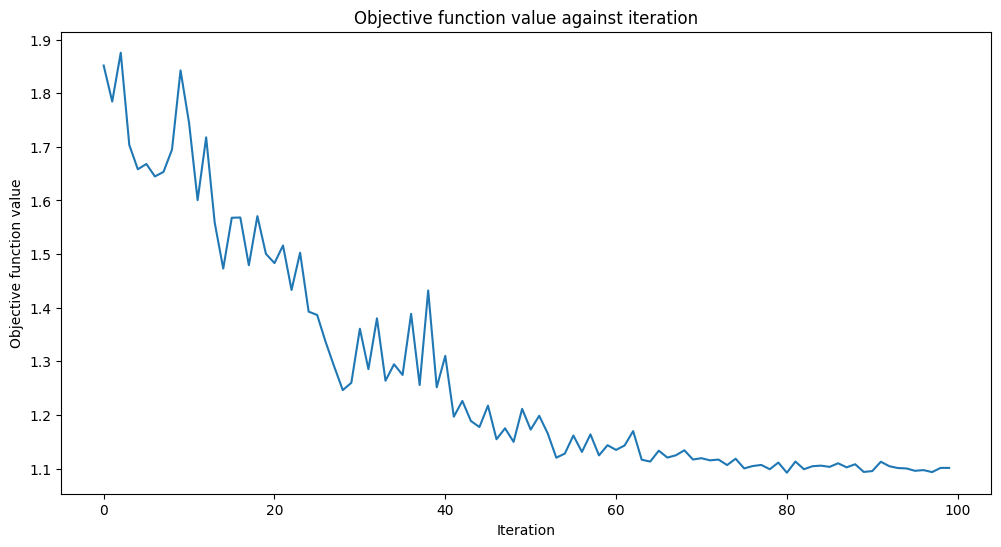

Training time: 160 seconds


In [29]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
    output_shape=num_classes,
    interpret=multi_class_interpret  # interpret 함수 추가
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [30]:
train_score_q4 = vqc.score(train_features, train_labels)
test_score_q4 = vqc.score(test_features, test_labels)

# print the scores of the quantum model
print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.78
Quantum VQC on the test dataset:     0.70


In [31]:
y_pred =  vqc.predict(test_features)